# TP 3
Camille BROSSETTE  
Maxime LEGRAND

## Data import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
dft = {}
dft[1] = pd.read_pickle("../data_trades/strades_info_720.h5")
dft[2] = pd.read_pickle('../data_trades/strades_info_1102.h5')
dft[3] = pd.read_pickle('../data_trades/strades_info_1662.h5')
dft[4] = pd.read_pickle('../data_trades/strades_info_1664.h5')
dft[5] = pd.read_pickle('../data_trades/strades_info_2255.h5')
dft[6] = pd.read_pickle('../data_trades/strades_info_2574.h5')
dft[7] = pd.read_pickle('../data_trades/strades_info_2586.h5')
dft[8] = pd.read_pickle('../data_trades/strades_info_5685.h5')
dft[9] = pd.read_pickle('../data_trades/strades_info_8695864.h5')

## Cleaning

In [3]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [4]:
dftt = {}
for i in range(1,10):
    dftt[i] = dft[i].set_index('ts_market')

## Choix de l'ensemble considéré dans la suite

In [5]:
I = 5 # Determines the set we are considering for now : choose among [1, ..., 9].
J = 4

## Signature plot

In [6]:
def sign_vol(A, Time_Step):
    
    vol = A['price'].resample(Time_Step, how='first').fillna(method='ffill')
    #vol = np.log(vol)
    vol = ((vol-vol.shift())**2)
    
    return vol.sum()

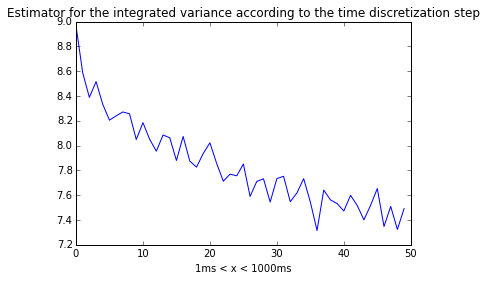

In [7]:
Sign_Vol = [sign_vol(dftt[I], (str(j) + 'ms')) for j in range(1,1000,20)]

plt.plot(Sign_Vol)
plt.title('Estimator for the integrated variance according to the time discretization step')
plt.xlabel('1ms < x < 1000ms')
plt.show()


Comme attendu, on obtient une explosion lorsque le pas de temps tend vers 0.

## Intraday Volatility Estimator of Garman and Klass

In [8]:
def GK_Vol(A, Time_Step):
    
    High = A['price'].resample(Time_Step, how='max').fillna(method='ffill')
    Low = A['price'].resample(Time_Step, how='min').fillna(method='ffill')
    Open = A['price'].resample(Time_Step, how='first').fillna(method='ffill')
    Close = A['price'].resample(Time_Step, how='last').fillna(method='ffill')
    
    vol = 0.5*(High - Low)**2 - (2 * np.log(2) - 1)*(Close - Open)**2
    
    return np.sqrt(vol)

In [9]:
GKV = {}
Time = {}

for s in ['30s', '1Min', '2Min', '5Min']:
    GKV[s] = GK_Vol(dftt[I], s)
    Time[s] = np.linspace(8,16.5,len(GKV[s]))


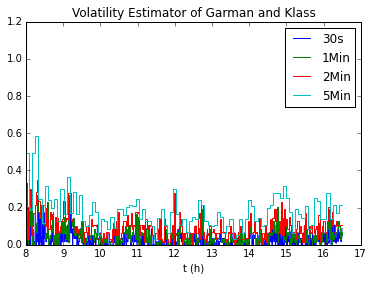

In [10]:
for s in ['30s', '1Min', '2Min', '5Min']:
    plt.step(Time[s], GKV[s], label = s)

plt.title('Volatility Estimator of Garman and Klass')
plt.xlabel('t (h)')
plt.legend()
plt.show()

On remarque que, globalement, plus on réduit le pas de temps, moins la volatilité estimée est grande.

## Intraday Volatility Estimator (natural)

In [11]:
def Classic_Vol(A, time_step):
    
    vol = (((A['price'].diff())**2).resample(time_step, how='sum')).apply(np.sqrt)
    
    return vol    

In [12]:
CV = {}

for s in ['30s', '1Min', '2Min', '5Min']:
    CV[s] = Classic_Vol(dftt[I], s)

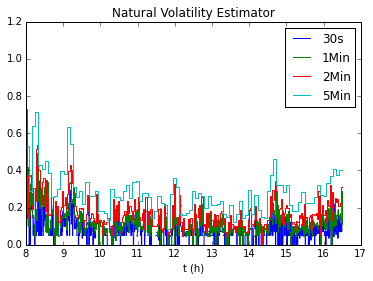

In [13]:
for s in ['30s', '1Min', '2Min', '5Min']:
    plt.step(Time[s], CV[s], label = s)

plt.title('Natural Volatility Estimator')
plt.xlabel('t (h)')
plt.legend()
plt.show()

Comme la GK Volatility, plus on réduit le pas de temps, moins la Classic volatility estimée est grande

## Comparaison des estimateurs

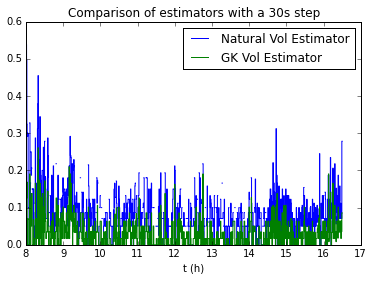

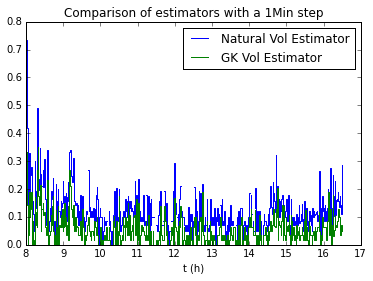

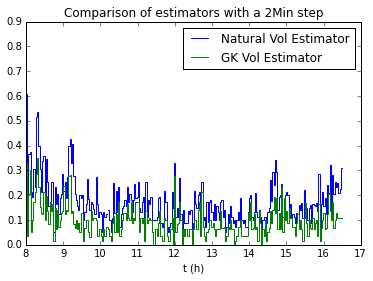

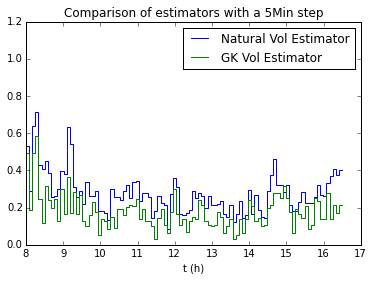

In [14]:
for s in ['30s', '1Min', '2Min', '5Min']:
    plt.step(Time[s] ,CV[s], label='Natural Vol Estimator')
    plt.step(Time[s], GKV[s], label='GK Vol Estimator')
    plt.title('Comparison of estimators with a '+s+' step')
    plt.xlabel('t (h)')
    plt.legend()
    plt.show()



Plus le pas de temps est petit, plus la Classic Volatility surestime, comparée à la GK Volatility.

## "Classical" Covariance Estimator

In [15]:
def Classic_Corr(A, B, Time_Step):
    tmpA = A['price'].resample(Time_Step, how='first')#fillna(method='ffill')
    tmpB = B['price'].resample(Time_Step, how='first')#fillna(method='ffill')
    
    tmpA = np.log(tmpA)
    tmpB = np.log(tmpB)
    
    tmpA = np.abs(tmpA.diff())
    tmpB = np.abs(tmpB.diff())
    
    corr = 0
    
    for i in range(1,min(len(tmpB),len(tmpA))):
        if (not(np.isnan(tmpA[i]))) & (not(np.isnan(tmpB[i]))):
            corr = corr + (tmpA[i])*(tmpB[i])
            
    return corr

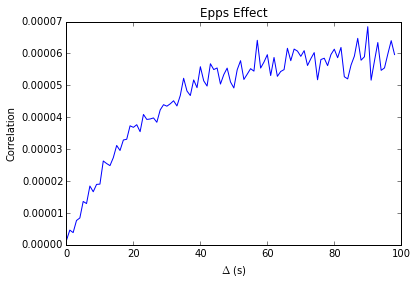

In [16]:
CC = [Classic_Corr(dftt[I], dftt[J], (str(j) + 's')) for j in range(1,100)]

plt.plot(CC)
plt.title('Epps Effect')
plt.ylabel('Correlation')
plt.xlabel('$\Delta$ (s)')
plt.show()

L'estimateur classique de la covariance tend vers 0 lorsque le pas de temps tend vers 0: La corrélation entre les prix des différents stock décroit lorsque le pas de temps décroit.